In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

print("alpha",alpha)
print(datetime.datetime.now())

alpha 0.1
2023-06-08 06:19:51.535615


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-3.0514)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-3.4609)
penalty_target_min tensor(-11.9806) penalty_target_max tensor(3.1330)
train_loss:  -9.819340663146972
valid_loss:  -9.20669306640625
h_min_tilde -11.980572 ell_tilde -9.69681114379883 kappa_tilde 0.0006617206865259105


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 2.1457672119140625e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 4.655006408691406

 2 4.6696741580963135

 3 4.691335439682007

 4 4.187145709991455

 5 4.2374608516693115

 6 4.2377684116363525

 7 4.160423517227173

 8 4.165199518203735

 9 4.116424798965454

 10 4.2550048828125

 11 4.173358917236328

 12 4.2627246379852295

 13 4.2548136711120605

 14 4.2296013832092285

 15 4.252757549285889

 16 4.245060205459595

 17 4.837863206863403

 18 4.832792282104492

 19 5.391345262527466

 20 4.187363862991333

 21 4.142606019973755

 22 4.10165548324585

 23 4.192760944366455

 24 4.140507698059082

 25 4.268097162246704

 26 4.072534084320068

 27 4.238879203796387

 28 4.164356231689453

 29 4.056773662567139

 30 4.140526533126831

 31 4.216770648956299

 32 4.1846764087677

 33 4.140662670135498

 34 4.084119558334351

 35 4.062248468399048

 36 4.124530553817749

 37 4.298864126205444

 38 4.112956523895264

 39 4.095105409622192

 40 4.110168218612671

 41 4.099985122680664

 42 4.134979963302612

 43 4.059735059738159

 44 3.990840673446

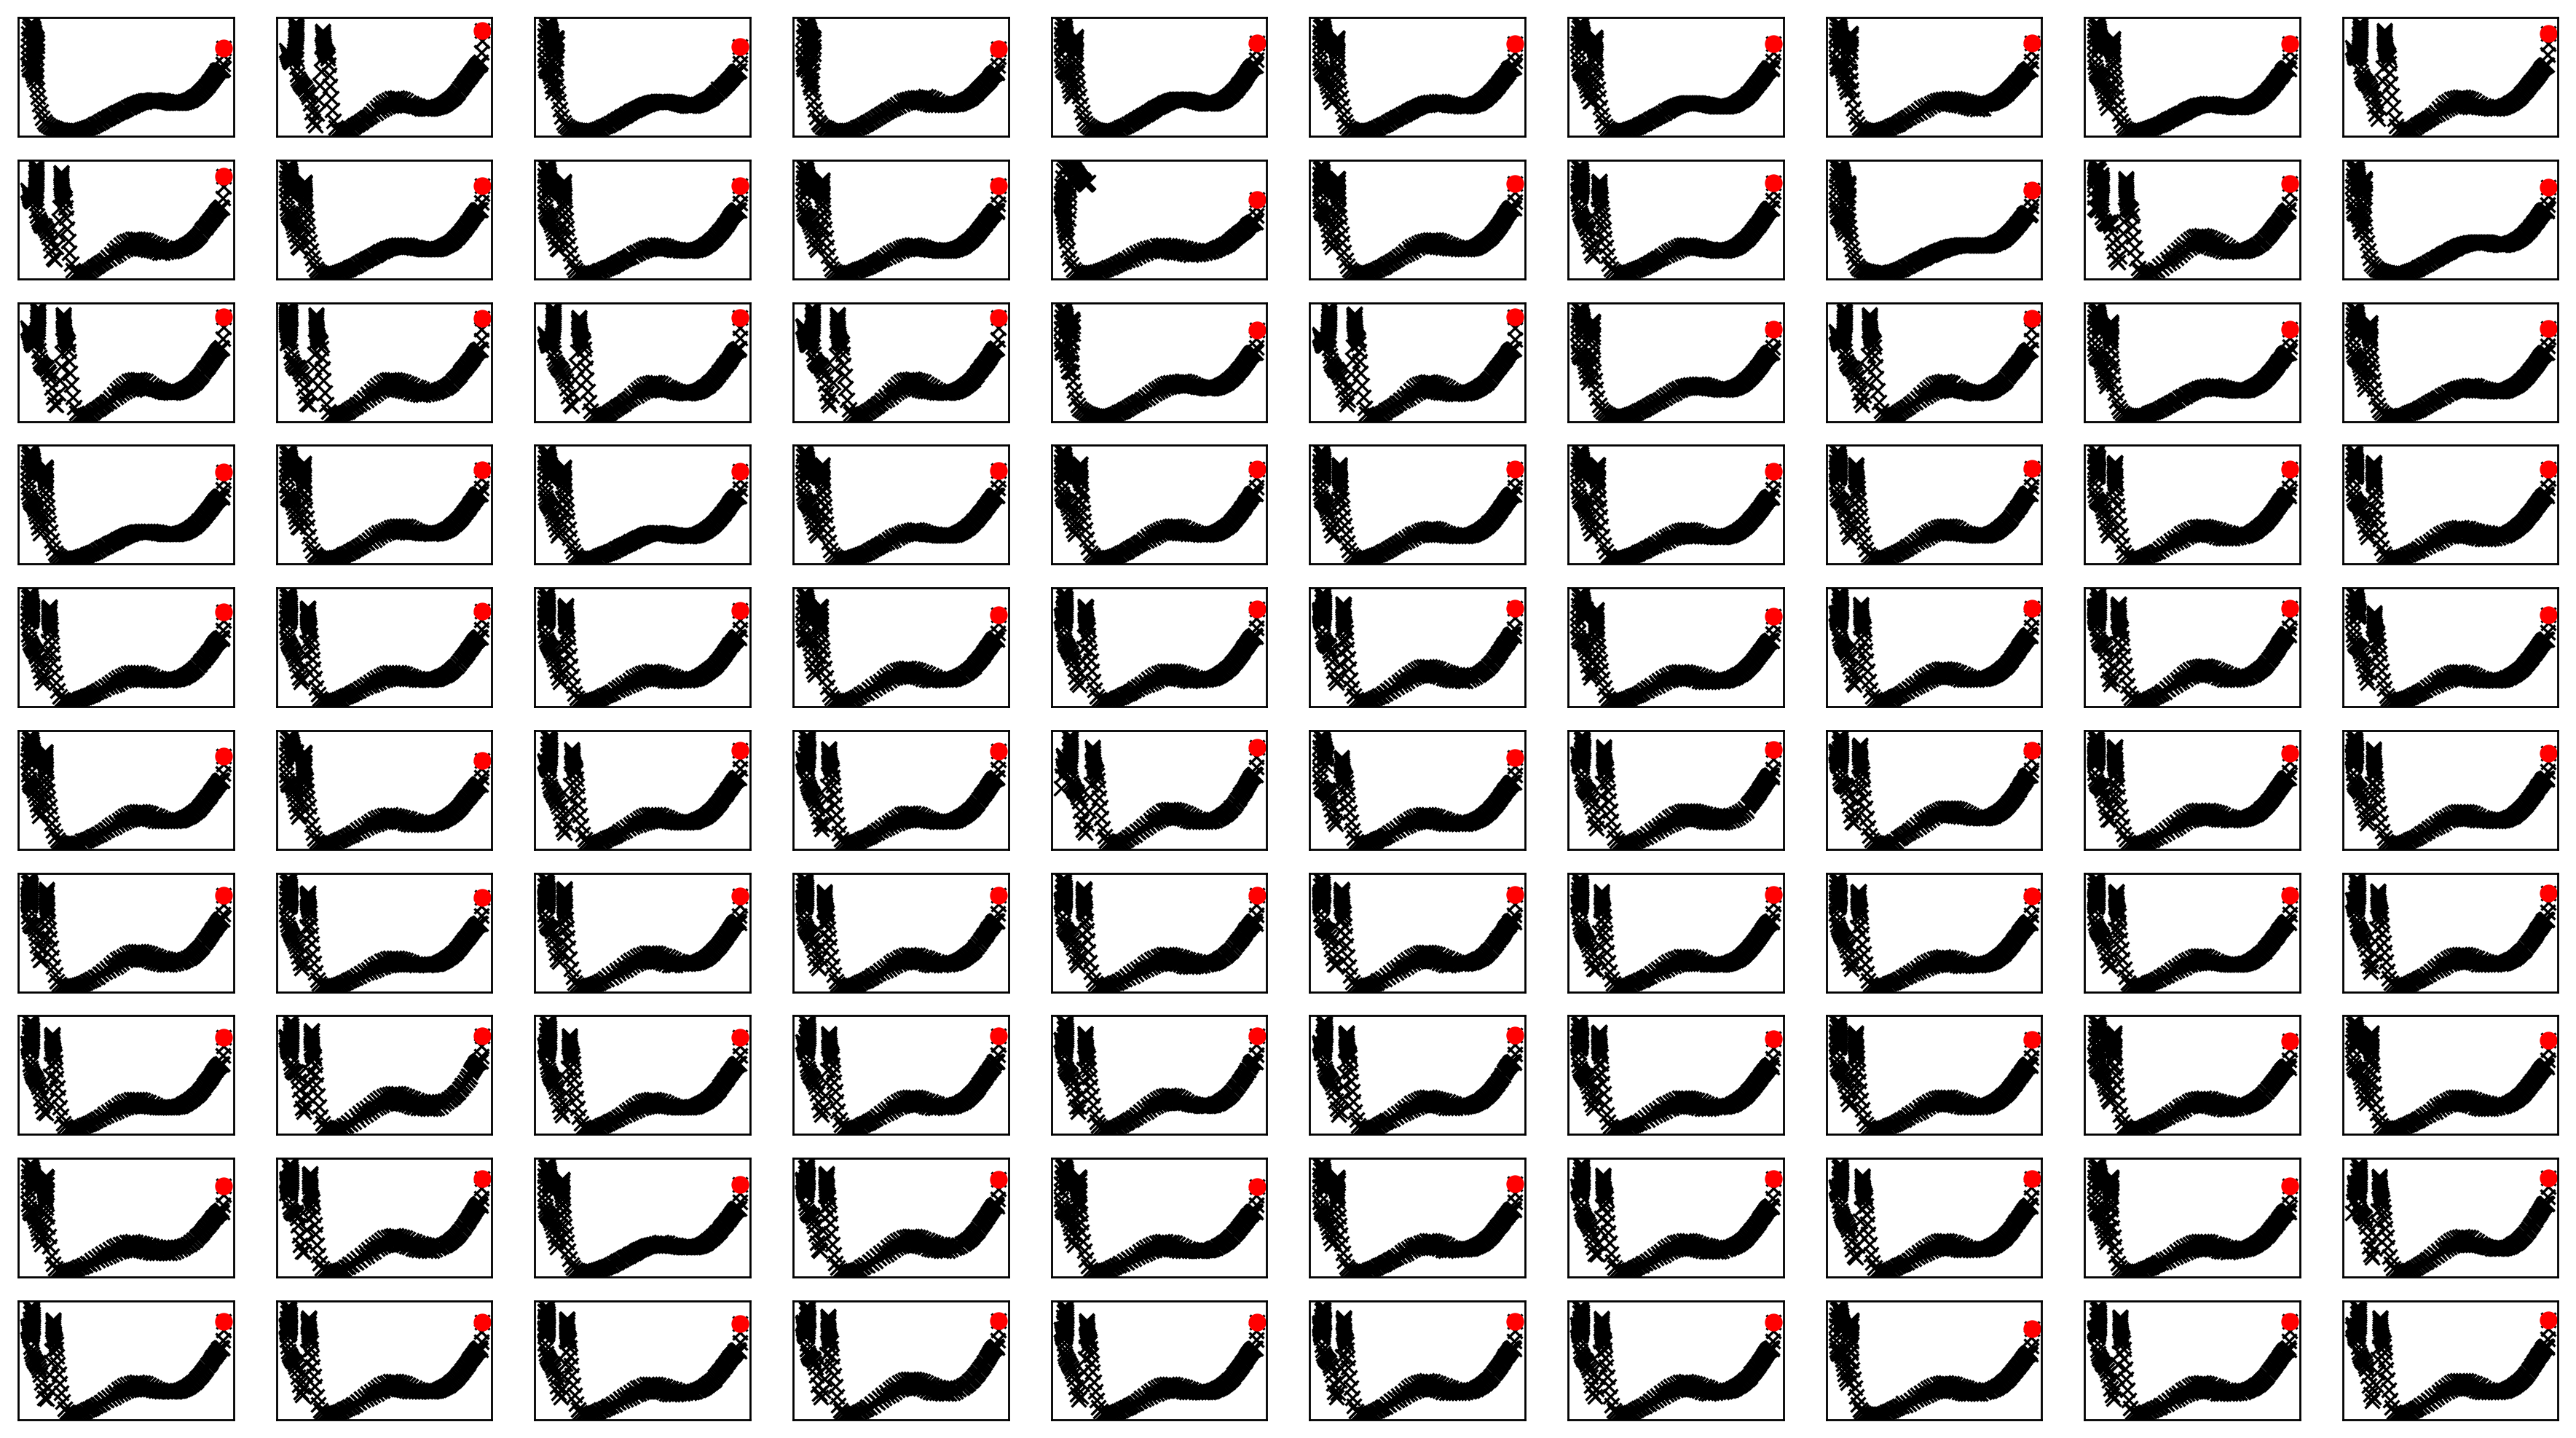

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

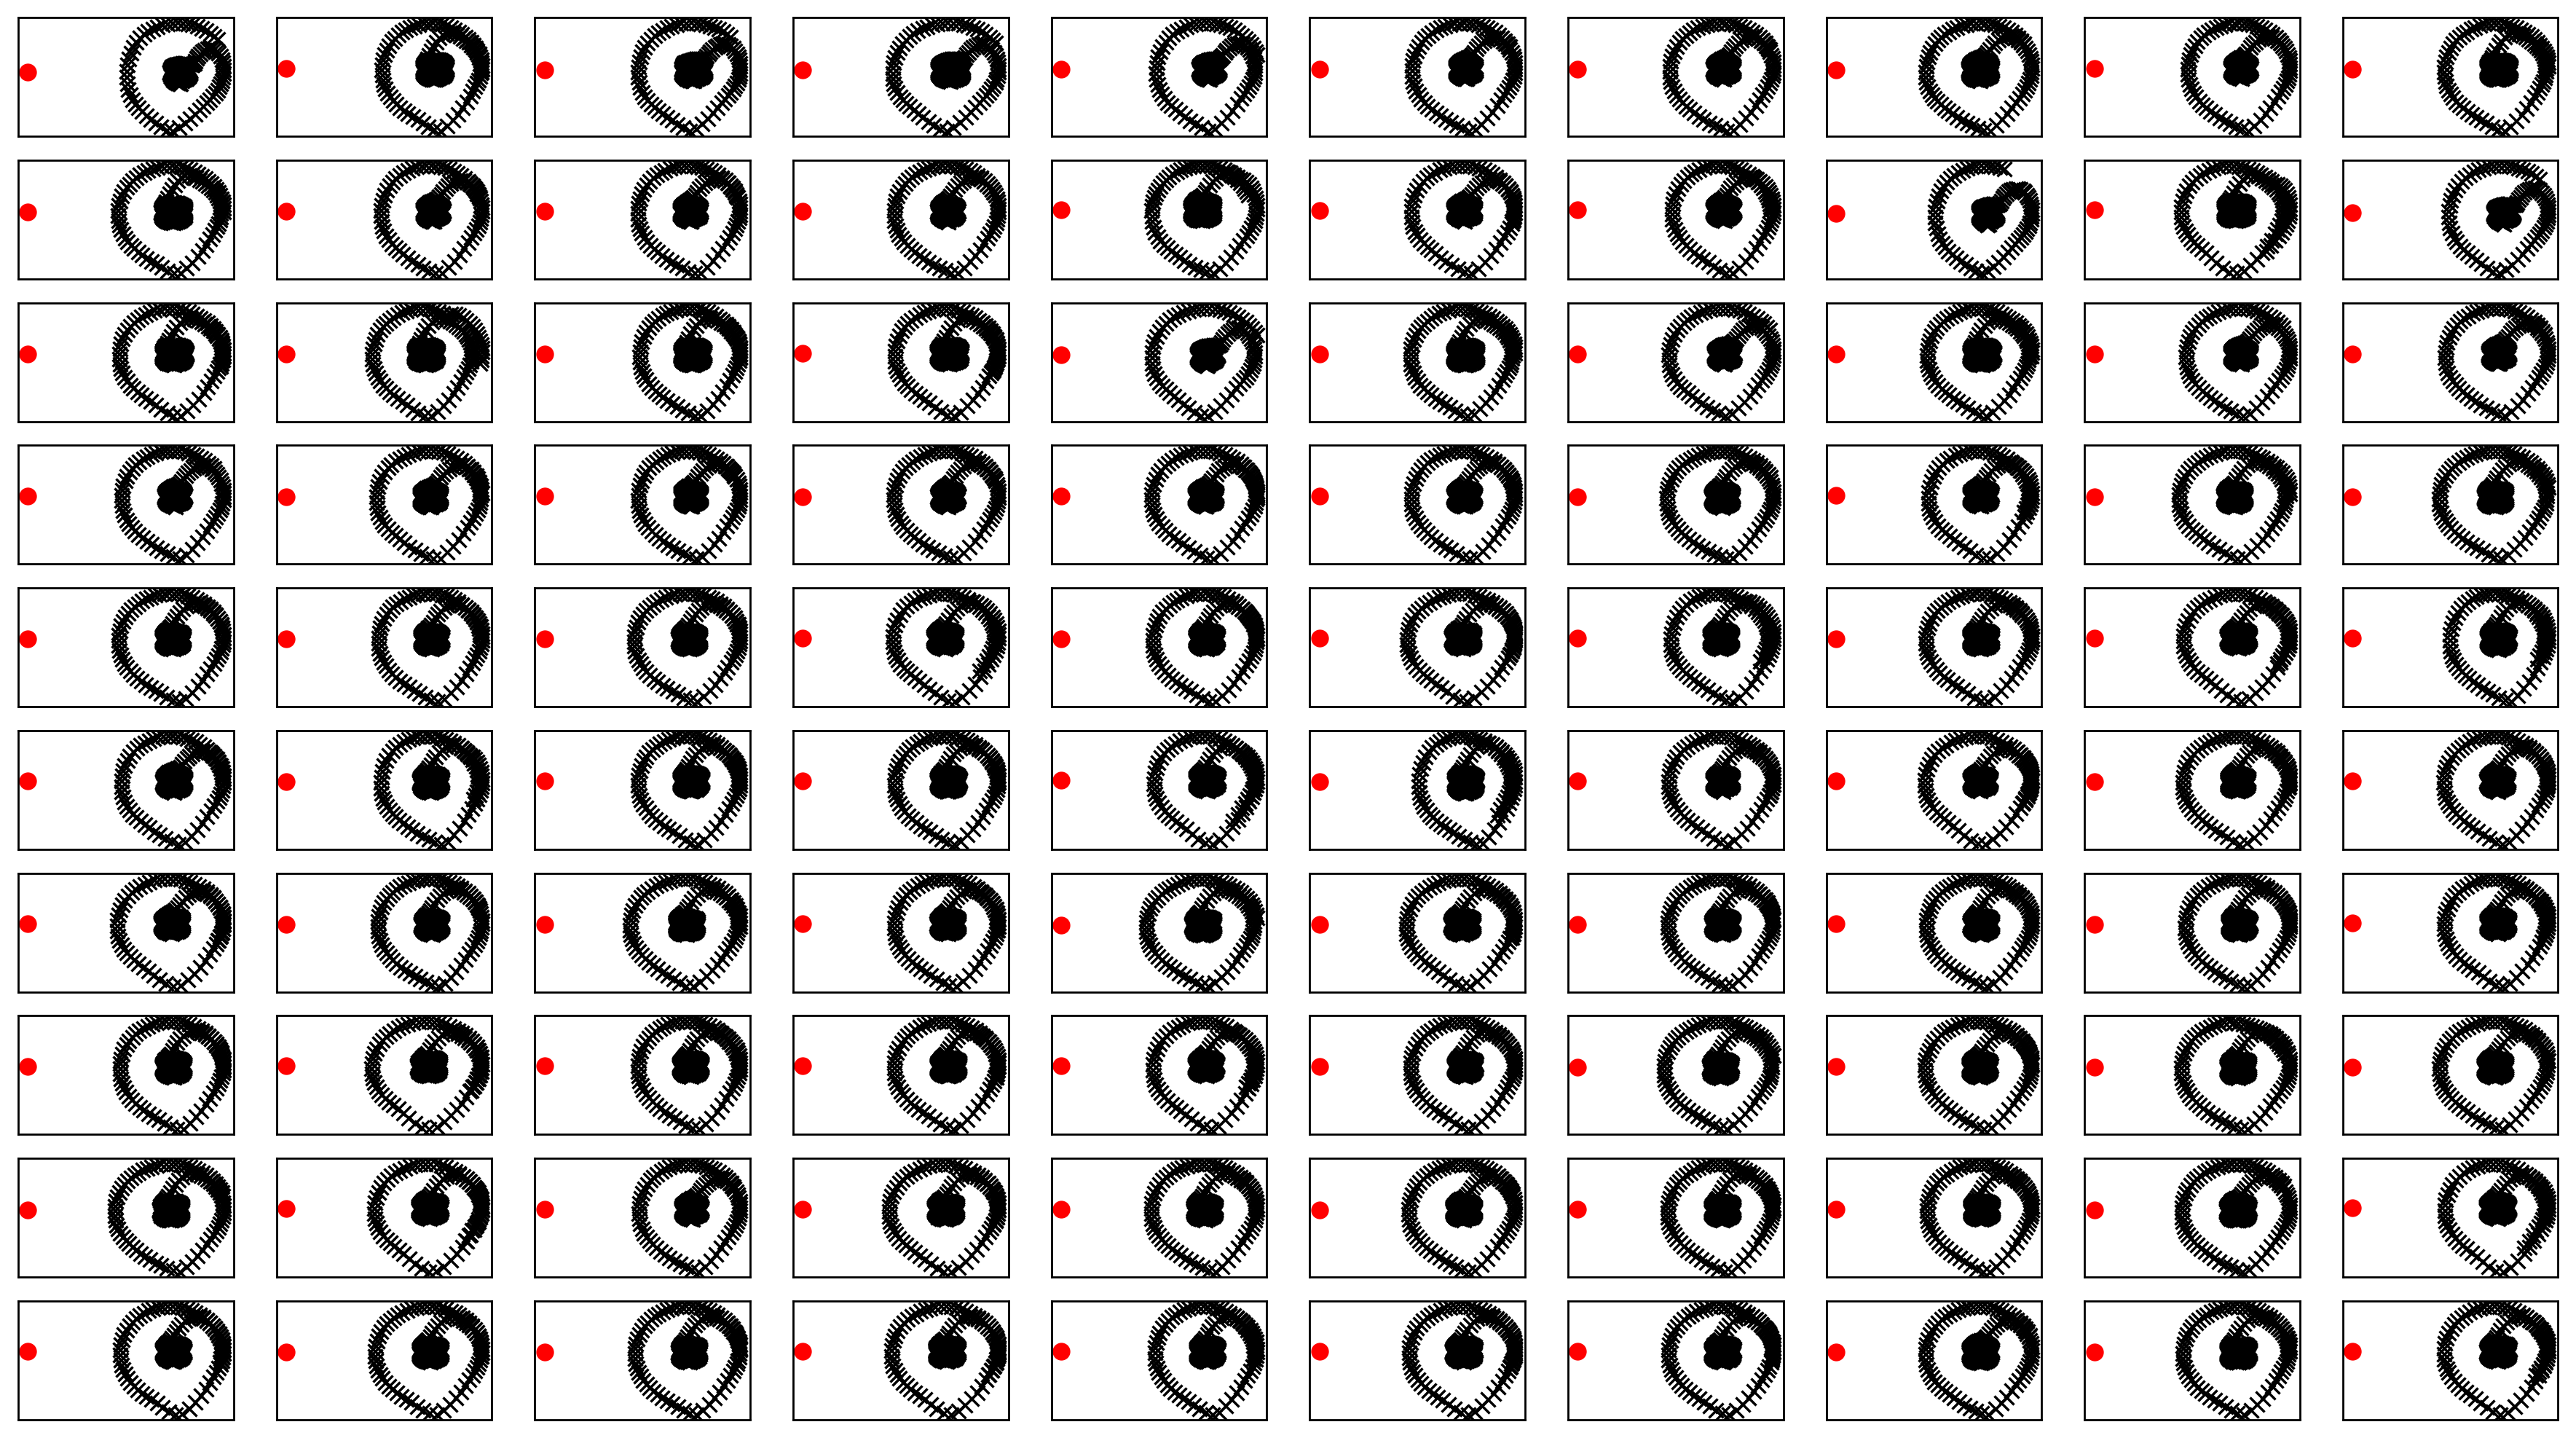

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-06-08 06:27:15.532803


# Iter 1

In [9]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11
predict diverge [  9.09013188   9.37074322 -16.87887208 -23.18150658] [ 0.20902756  0.28031886 -0.43088798 -1.57958037] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 123

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40
predict diverge [  5.32111918  10.35009014 -12.14969325 -17.9309605 ] [ 0.12131892  0.28307279 -0.23258193  0.23176185] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 98

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65
predict diverge [  6.94020973   7.82483142 -19.80387589 -22.69395788] [ 0.16253905 -0.94273285 -0.46885547 -1.73467924] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 126

 66



In [10]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.36901  validloss 1.40777±0.00000  bestvalidloss 1.40777  last_update 0
train: iter 1  trainloss 1.33681  validloss 1.33716±0.00000  bestvalidloss 1.33716  last_update 0
train: iter 2  trainloss 1.30962  validloss 1.29578±0.00000  bestvalidloss 1.29578  last_update 0
train: iter 3  trainloss 1.29069  validloss 1.26800±0.00000  bestvalidloss 1.26800  last_update 0
train: iter 4  trainloss 1.27217  validloss 1.24532±0.00000  bestvalidloss 1.24532  last_update 0
train: iter 5  trainloss 1.24821  validloss 1.21993±0.00000  bestvalidloss 1.21993  last_update 0
train: iter 6  trainloss 1.22501  validloss 1.19621±0.00000  bestvalidloss 1.19621  last_update 0
train: iter 7  trainloss 1.19580  validloss 1.16653±0.00000  bestvalidloss 1.16653  last_update 0
train: iter 8  trainloss 1.17116  validloss 1.13965±0.00000  bestvalidloss 1.13965  last_update 0
train: iter 9  trainloss 1.14871  validloss 1.11773±0.00000  bestvalidloss 1.11773  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.84939  validloss 0.87451±0.00000  bestvalidloss 0.85965  last_update 1
train: iter 84  trainloss 0.85349  validloss 0.86106±0.00000  bestvalidloss 0.85965  last_update 2
train: iter 85  trainloss 0.84516  validloss 0.86273±0.00000  bestvalidloss 0.85965  last_update 3
train: iter 86  trainloss 0.84973  validloss 0.86103±0.00000  bestvalidloss 0.85965  last_update 4
train: iter 87  trainloss 0.84693  validloss 0.86357±0.00000  bestvalidloss 0.85965  last_update 5
train: iter 88  trainloss 0.84044  validloss 0.85564±0.00000  bestvalidloss 0.85564  last_update 0
train: iter 89  trainloss 0.83534  validloss 0.87916±0.00000  bestvalidloss 0.85564  last_update 1
train: iter 90  trainloss 0.83029  validloss 0.86008±0.00000  bestvalidloss 0.85564  last_update 2
train: iter 91  trainloss 0.83624  validloss 0.87931±0.00000  bestvalidloss 0.85564  last_update 3
train: iter 92  trainloss 0.82564  validloss 0.86291±0.00000  bestvalidloss 0.85564  last_update 4
train: ite

train: iter 166  trainloss 0.72933  validloss 0.79225±0.00000  bestvalidloss 0.79225  last_update 0
train: iter 167  trainloss 0.72360  validloss 0.79841±0.00000  bestvalidloss 0.79225  last_update 1
train: iter 168  trainloss 0.72098  validloss 0.84913±0.00000  bestvalidloss 0.79225  last_update 2
train: iter 169  trainloss 0.72019  validloss 0.80848±0.00000  bestvalidloss 0.79225  last_update 3
train: iter 170  trainloss 0.70557  validloss 0.79775±0.00000  bestvalidloss 0.79225  last_update 4
train: iter 171  trainloss 0.73426  validloss 0.80975±0.00000  bestvalidloss 0.79225  last_update 5
train: iter 172  trainloss 0.71055  validloss 0.82277±0.00000  bestvalidloss 0.79225  last_update 6
train: iter 173  trainloss 0.70812  validloss 0.80031±0.00000  bestvalidloss 0.79225  last_update 7
train: iter 174  trainloss 0.71658  validloss 0.80728±0.00000  bestvalidloss 0.79225  last_update 8
train: iter 175  trainloss 0.70826  validloss 0.85456±0.00000  bestvalidloss 0.79225  last_update 9


train: iter 248  trainloss 0.62903  validloss 0.75447±0.00000  bestvalidloss 0.72706  last_update 2
train: iter 249  trainloss 0.63968  validloss 0.73173±0.00000  bestvalidloss 0.72706  last_update 3
train: iter 250  trainloss 0.64196  validloss 0.75674±0.00000  bestvalidloss 0.72706  last_update 4
train: iter 251  trainloss 0.64548  validloss 0.73711±0.00000  bestvalidloss 0.72706  last_update 5
train: iter 252  trainloss 0.64355  validloss 0.73818±0.00000  bestvalidloss 0.72706  last_update 6
train: iter 253  trainloss 0.64589  validloss 0.74121±0.00000  bestvalidloss 0.72706  last_update 7
train: iter 254  trainloss 0.63332  validloss 0.75173±0.00000  bestvalidloss 0.72706  last_update 8
train: iter 255  trainloss 0.63046  validloss 0.73330±0.00000  bestvalidloss 0.72706  last_update 9
train: iter 256  trainloss 0.63343  validloss 0.73342±0.00000  bestvalidloss 0.72706  last_update 10
train: iter 257  trainloss 0.63674  validloss 0.72174±0.00000  bestvalidloss 0.72174  last_update 0

train: iter 330  trainloss 0.57541  validloss 0.71512±0.00000  bestvalidloss 0.69382  last_update 1
train: iter 331  trainloss 0.58183  validloss 0.72775±0.00000  bestvalidloss 0.69382  last_update 2
train: iter 332  trainloss 0.58680  validloss 0.70724±0.00000  bestvalidloss 0.69382  last_update 3
train: iter 333  trainloss 0.57187  validloss 0.69166±0.00000  bestvalidloss 0.69166  last_update 0
train: iter 334  trainloss 0.58758  validloss 0.71377±0.00000  bestvalidloss 0.69166  last_update 1
train: iter 335  trainloss 0.59247  validloss 0.72511±0.00000  bestvalidloss 0.69166  last_update 2
train: iter 336  trainloss 0.58137  validloss 0.69403±0.00000  bestvalidloss 0.69166  last_update 3
train: iter 337  trainloss 0.57819  validloss 0.71282±0.00000  bestvalidloss 0.69166  last_update 4
train: iter 338  trainloss 0.57690  validloss 0.69998±0.00000  bestvalidloss 0.69166  last_update 5
train: iter 339  trainloss 0.57783  validloss 0.73847±0.00000  bestvalidloss 0.69166  last_update 6


train: iter 412  trainloss 0.54625  validloss 0.67930±0.00000  bestvalidloss 0.67285  last_update 5
train: iter 413  trainloss 0.55150  validloss 0.67956±0.00000  bestvalidloss 0.67285  last_update 6
train: iter 414  trainloss 0.55717  validloss 0.68148±0.00000  bestvalidloss 0.67285  last_update 7
train: iter 415  trainloss 0.54298  validloss 0.69826±0.00000  bestvalidloss 0.67285  last_update 8
train: iter 416  trainloss 0.55181  validloss 0.68377±0.00000  bestvalidloss 0.67285  last_update 9
train: iter 417  trainloss 0.55181  validloss 0.69548±0.00000  bestvalidloss 0.67285  last_update 10
train: iter 418  trainloss 0.55483  validloss 0.69597±0.00000  bestvalidloss 0.67285  last_update 11
train: iter 419  trainloss 0.53662  validloss 0.67498±0.00000  bestvalidloss 0.67285  last_update 12
train: iter 420  trainloss 0.54629  validloss 0.68007±0.00000  bestvalidloss 0.67285  last_update 13
train: iter 421  trainloss 0.54872  validloss 0.74006±0.00000  bestvalidloss 0.67285  last_updat

train: iter 494  trainloss 0.51789  validloss 0.69569±0.00000  bestvalidloss 0.65001  last_update 16
train: iter 495  trainloss 0.52689  validloss 0.67453±0.00000  bestvalidloss 0.65001  last_update 17
train: iter 496  trainloss 0.52371  validloss 0.66914±0.00000  bestvalidloss 0.65001  last_update 18
train: iter 497  trainloss 0.52251  validloss 0.68121±0.00000  bestvalidloss 0.65001  last_update 19
train: iter 498  trainloss 0.53147  validloss 0.69457±0.00000  bestvalidloss 0.65001  last_update 20
train: iter 499  trainloss 0.51452  validloss 0.67353±0.00000  bestvalidloss 0.65001  last_update 21
train: iter 500  trainloss 0.51532  validloss 0.68476±0.00000  bestvalidloss 0.65001  last_update 22
train: iter 501  trainloss 0.52089  validloss 0.67456±0.00000  bestvalidloss 0.65001  last_update 23
train: iter 502  trainloss 0.52604  validloss 0.65164±0.00000  bestvalidloss 0.65001  last_update 24
train: iter 503  trainloss 0.52434  validloss 0.67291±0.00000  bestvalidloss 0.65001  last_

train: iter 576  trainloss 0.50662  validloss 0.67000±0.00000  bestvalidloss 0.63887  last_update 31
train: iter 577  trainloss 0.51640  validloss 0.67544±0.00000  bestvalidloss 0.63887  last_update 32
train: iter 578  trainloss 0.50087  validloss 0.67246±0.00000  bestvalidloss 0.63887  last_update 33
train: iter 579  trainloss 0.49943  validloss 0.66583±0.00000  bestvalidloss 0.63887  last_update 34
train: iter 580  trainloss 0.49434  validloss 0.69869±0.00000  bestvalidloss 0.63887  last_update 35
train: iter 581  trainloss 0.49466  validloss 0.69748±0.00000  bestvalidloss 0.63887  last_update 36
train: iter 582  trainloss 0.50394  validloss 0.64959±0.00000  bestvalidloss 0.63887  last_update 37
train: iter 583  trainloss 0.50192  validloss 0.65495±0.00000  bestvalidloss 0.63887  last_update 38
train: iter 584  trainloss 0.50707  validloss 0.67586±0.00000  bestvalidloss 0.63887  last_update 39
train: iter 585  trainloss 0.50649  validloss 0.63583±0.00000  bestvalidloss 0.63583  last_

train: iter 658  trainloss 0.47912  validloss 0.66390±0.00000  bestvalidloss 0.62698  last_update 1
train: iter 659  trainloss 0.47970  validloss 0.62685±0.00000  bestvalidloss 0.62685  last_update 0
train: iter 660  trainloss 0.48546  validloss 0.67098±0.00000  bestvalidloss 0.62685  last_update 1
train: iter 661  trainloss 0.47310  validloss 0.64559±0.00000  bestvalidloss 0.62685  last_update 2
train: iter 662  trainloss 0.47502  validloss 0.64945±0.00000  bestvalidloss 0.62685  last_update 3
train: iter 663  trainloss 0.47973  validloss 0.64113±0.00000  bestvalidloss 0.62685  last_update 4
train: iter 664  trainloss 0.48159  validloss 0.67156±0.00000  bestvalidloss 0.62685  last_update 5
train: iter 665  trainloss 0.48145  validloss 0.63605±0.00000  bestvalidloss 0.62685  last_update 6
train: iter 666  trainloss 0.47082  validloss 0.63168±0.00000  bestvalidloss 0.62685  last_update 7
train: iter 667  trainloss 0.48535  validloss 0.68630±0.00000  bestvalidloss 0.62685  last_update 8


train: iter 740  trainloss 0.46377  validloss 0.65521±0.00000  bestvalidloss 0.61925  last_update 31
train: iter 741  trainloss 0.46376  validloss 0.65026±0.00000  bestvalidloss 0.61925  last_update 32
train: iter 742  trainloss 0.46099  validloss 0.64041±0.00000  bestvalidloss 0.61925  last_update 33
train: iter 743  trainloss 0.47250  validloss 0.62877±0.00000  bestvalidloss 0.61925  last_update 34
train: iter 744  trainloss 0.46641  validloss 0.63422±0.00000  bestvalidloss 0.61925  last_update 35
train: iter 745  trainloss 0.46637  validloss 0.62923±0.00000  bestvalidloss 0.61925  last_update 36
train: iter 746  trainloss 0.46299  validloss 0.62822±0.00000  bestvalidloss 0.61925  last_update 37
train: iter 747  trainloss 0.44979  validloss 0.64358±0.00000  bestvalidloss 0.61925  last_update 38
train: iter 748  trainloss 0.45702  validloss 0.64406±0.00000  bestvalidloss 0.61925  last_update 39
train: iter 749  trainloss 0.45824  validloss 0.63482±0.00000  bestvalidloss 0.61925  last_

train: iter 822  trainloss 0.47043  validloss 0.63063±0.00000  bestvalidloss 0.60784  last_update 5
train: iter 823  trainloss 0.44339  validloss 0.61652±0.00000  bestvalidloss 0.60784  last_update 6
train: iter 824  trainloss 0.44671  validloss 0.60893±0.00000  bestvalidloss 0.60784  last_update 7
train: iter 825  trainloss 0.45875  validloss 0.61105±0.00000  bestvalidloss 0.60784  last_update 8
train: iter 826  trainloss 0.44124  validloss 0.63867±0.00000  bestvalidloss 0.60784  last_update 9
train: iter 827  trainloss 0.44708  validloss 0.64009±0.00000  bestvalidloss 0.60784  last_update 10
train: iter 828  trainloss 0.44987  validloss 0.65199±0.00000  bestvalidloss 0.60784  last_update 11
train: iter 829  trainloss 0.44345  validloss 0.63321±0.00000  bestvalidloss 0.60784  last_update 12
train: iter 830  trainloss 0.44591  validloss 0.63123±0.00000  bestvalidloss 0.60784  last_update 13
train: iter 831  trainloss 0.45265  validloss 0.62785±0.00000  bestvalidloss 0.60784  last_updat

train: iter 904  trainloss 0.43766  validloss 0.61742±0.00000  bestvalidloss 0.59810  last_update 50
train: iter 905  trainloss 0.43404  validloss 0.61783±0.00000  bestvalidloss 0.59810  last_update 51
train: iter 906  trainloss 0.42560  validloss 0.63630±0.00000  bestvalidloss 0.59810  last_update 52
train: iter 907  trainloss 0.43304  validloss 0.61750±0.00000  bestvalidloss 0.59810  last_update 53
train: iter 908  trainloss 0.42519  validloss 0.63685±0.00000  bestvalidloss 0.59810  last_update 54
train: iter 909  trainloss 0.43140  validloss 0.60759±0.00000  bestvalidloss 0.59810  last_update 55
train: iter 910  trainloss 0.43242  validloss 0.62829±0.00000  bestvalidloss 0.59810  last_update 56
train: iter 911  trainloss 0.43636  validloss 0.62764±0.00000  bestvalidloss 0.59810  last_update 57
train: iter 912  trainloss 0.43391  validloss 0.59833±0.00000  bestvalidloss 0.59810  last_update 58
train: iter 913  trainloss 0.42189  validloss 0.60602±0.00000  bestvalidloss 0.59810  last_

train: iter 986  trainloss 0.41312  validloss 0.62586±0.00000  bestvalidloss 0.58511  last_update 5
train: iter 987  trainloss 0.41197  validloss 0.66419±0.00000  bestvalidloss 0.58511  last_update 6
train: iter 988  trainloss 0.41045  validloss 0.59494±0.00000  bestvalidloss 0.58511  last_update 7
train: iter 989  trainloss 0.41092  validloss 0.61442±0.00000  bestvalidloss 0.58511  last_update 8
train: iter 990  trainloss 0.41909  validloss 0.59680±0.00000  bestvalidloss 0.58511  last_update 9
train: iter 991  trainloss 0.40721  validloss 0.59100±0.00000  bestvalidloss 0.58511  last_update 10
train: iter 992  trainloss 0.41105  validloss 0.62692±0.00000  bestvalidloss 0.58511  last_update 11
train: iter 993  trainloss 0.41348  validloss 0.61140±0.00000  bestvalidloss 0.58511  last_update 12
train: iter 994  trainloss 0.40914  validloss 0.60204±0.00000  bestvalidloss 0.58511  last_update 13
train: iter 995  trainloss 0.40699  validloss 0.61330±0.00000  bestvalidloss 0.58511  last_updat

train: iter 1067  trainloss 0.39593  validloss 0.60518±0.00000  bestvalidloss 0.58294  last_update 70
train: iter 1068  trainloss 0.39628  validloss 0.63329±0.00000  bestvalidloss 0.58294  last_update 71
train: iter 1069  trainloss 0.39250  validloss 0.60650±0.00000  bestvalidloss 0.58294  last_update 72
train: iter 1070  trainloss 0.39518  validloss 0.59399±0.00000  bestvalidloss 0.58294  last_update 73
train: iter 1071  trainloss 0.42860  validloss 0.67584±0.00000  bestvalidloss 0.58294  last_update 74
train: iter 1072  trainloss 0.40148  validloss 0.61250±0.00000  bestvalidloss 0.58294  last_update 75
train: iter 1073  trainloss 0.39281  validloss 0.59325±0.00000  bestvalidloss 0.58294  last_update 76
train: iter 1074  trainloss 0.39429  validloss 0.61595±0.00000  bestvalidloss 0.58294  last_update 77
train: iter 1075  trainloss 0.40018  validloss 0.59670±0.00000  bestvalidloss 0.58294  last_update 78
train: iter 1076  trainloss 0.39227  validloss 0.59834±0.00000  bestvalidloss 0.58

([1.369009856879711,
  1.3368090689182281,
  1.309623020887375,
  1.290688904374838,
  1.272166308015585,
  1.2482084274291991,
  1.2250084288418293,
  1.1958016104996205,
  1.1711628571152688,
  1.148714542388916,
  1.1303005561232566,
  1.1171918213367462,
  1.1012545019388198,
  1.0923623599112033,
  1.0795167706906796,
  1.0707425974309444,
  1.0821359306573868,
  1.0635320529341699,
  1.0573951862752438,
  1.0498350150883198,
  1.0438715003430843,
  1.0438631422817708,
  1.035643783956766,
  1.03057244643569,
  1.0237733192741871,
  1.0232074372470379,
  1.0144910931587219,
  1.0136405684053897,
  1.0047197856009007,
  1.0004860535264015,
  1.0080543853342534,
  0.9916321188211441,
  0.9906862512230873,
  0.9951346106827259,
  0.9842361330986023,
  0.9770677454769612,
  0.9868348605930806,
  0.970767506211996,
  0.9689958602190017,
  0.966873187571764,
  0.9606934368610383,
  0.9653721004724503,
  0.9603791408240795,
  0.9544480174779892,
  0.9532117247581482,
  0.946432001888752,

In [11]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -3.824169810706377
valid_loss:  -7.26065238213539
weight_alpha 1.0 h_min_tilde -11.980572 ell_tilde -4.511466324992179 kappa_tilde 0.00036590277683548264
train_loss:  -5.225154494094849
valid_loss:  -5.193374036407471
weight_alpha 0.1 h_min_tilde -11.980572 ell_tilde -5.218798402557374 kappa_tilde 0.00038456494664755136


In [12]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1011.66232  validloss -1039.26076±0.00000  bestvalidloss -1039.26076  last_update 0
train: iter 1  trainloss -1018.55962  validloss -1008.82573±0.00000  bestvalidloss -1039.26076  last_update 1
train: iter 2  trainloss -992.21379  validloss -1002.20774±0.00000  bestvalidloss -1039.26076  last_update 2
train: iter 3  trainloss -1024.11369  validloss -1002.08551±0.00000  bestvalidloss -1039.26076  last_update 3
train: iter 4  trainloss -1026.03026  validloss -1006.56263±0.00000  bestvalidloss -1039.26076  last_update 4
train: iter 5  trainloss -1020.91866  validloss -995.69576±0.00000  bestvalidloss -1039.26076  last_update 5
train: iter 6  trainloss -1017.66569  validloss -997.13221±0.00000  bestvalidloss -1039.26076  last_update 6
train: iter 7  trainloss -1003.31824  validloss -978.54461±0.00000  bestvalidloss -1039.26076  last_update 7
train: iter 8  trainloss -1020.20334  validloss -978.27943±0.00000  bestvalidlo

train: iter 74  trainloss -1014.80754  validloss -956.84683±0.00000  bestvalidloss -1039.26076  last_update 74
train: iter 75  trainloss -1034.40696  validloss -958.45515±0.00000  bestvalidloss -1039.26076  last_update 75
train: iter 76  trainloss -1027.18797  validloss -944.69287±0.00000  bestvalidloss -1039.26076  last_update 76
train: iter 77  trainloss -1023.28412  validloss -956.64670±0.00000  bestvalidloss -1039.26076  last_update 77
train: iter 78  trainloss -1017.53574  validloss -958.59942±0.00000  bestvalidloss -1039.26076  last_update 78
train: iter 79  trainloss -1030.38132  validloss -954.11864±0.00000  bestvalidloss -1039.26076  last_update 79
train: iter 80  trainloss -1024.84838  validloss -957.97702±0.00000  bestvalidloss -1039.26076  last_update 80
train: iter 81  trainloss -994.09477  validloss -923.01986±0.00000  bestvalidloss -1039.26076  last_update 81
train: iter 82  trainloss -1017.59840  validloss -955.41872±0.00000  bestvalidloss -1039.26076  last_update 82
tr

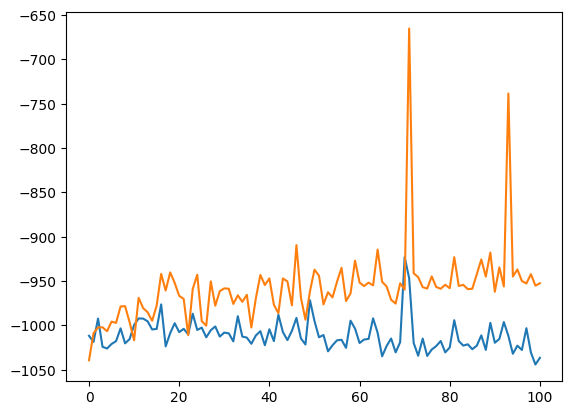

alpha 0.1 default_lr 0.0005


In [13]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [14]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [15]:
print(datetime.datetime.now())

2023-06-08 06:58:25.229679


# Iter2

In [16]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9
predict diverge [ 16.23287184  10.87919159 -16.34746004 -20.44444151] [ 0.25005033  0.96657253 -0.207642   -0.51328376] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 179

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55
predict diverge [-12.45095434 -10.46002755  -3.48919967  -3.55412407] [-0.30874814 -0.27535323 -0.07018393 -0.00421997] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 161

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69
predict diverge [  6.80525982  10.48617236  -8.13430446 -15.36242004] [ 0.17110824  0.18889577 -0.12575101 -0.08562111] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] si

In [17]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.69824  validloss 1.49386±0.00000  bestvalidloss 1.49386  last_update 0
train: iter 1  trainloss 0.55020  validloss 0.68208±0.00000  bestvalidloss 0.68208  last_update 0
train: iter 2  trainloss 0.51249  validloss 0.69742±0.00000  bestvalidloss 0.68208  last_update 1
train: iter 3  trainloss 0.51031  validloss 0.66590±0.00000  bestvalidloss 0.66590  last_update 0
train: iter 4  trainloss 0.50357  validloss 0.63824±0.00000  bestvalidloss 0.63824  last_update 0
train: iter 5  trainloss 0.49897  validloss 0.63882±0.00000  bestvalidloss 0.63824  last_update 1
train: iter 6  trainloss 0.50627  validloss 0.64413±0.00000  bestvalidloss 0.63824  last_update 2
train: iter 7  trainloss 0.48962  validloss 0.62052±0.00000  bestvalidloss 0.62052  last_update 0
train: iter 8  trainloss 0.48407  validloss 0.66706±0.00000  bestvalidloss 0.62052  last_update 1
train: iter 9  trainloss 0.47511  validloss 0.64045±0.00000  bestvalidloss 0.62052  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.43126  validloss 0.58985±0.00000  bestvalidloss 0.56159  last_update 17
train: iter 84  trainloss 0.45599  validloss 0.58645±0.00000  bestvalidloss 0.56159  last_update 18
train: iter 85  trainloss 0.42667  validloss 0.58888±0.00000  bestvalidloss 0.56159  last_update 19
train: iter 86  trainloss 0.42709  validloss 0.56600±0.00000  bestvalidloss 0.56159  last_update 20
train: iter 87  trainloss 0.42578  validloss 0.58629±0.00000  bestvalidloss 0.56159  last_update 21
train: iter 88  trainloss 0.42427  validloss 0.56509±0.00000  bestvalidloss 0.56159  last_update 22
train: iter 89  trainloss 0.42467  validloss 0.56796±0.00000  bestvalidloss 0.56159  last_update 23
train: iter 90  trainloss 0.43315  validloss 0.59493±0.00000  bestvalidloss 0.56159  last_update 24
train: iter 91  trainloss 0.42544  validloss 0.58054±0.00000  bestvalidloss 0.56159  last_update 25
train: iter 92  trainloss 0.42493  validloss 0.56360±0.00000  bestvalidloss 0.56159  last_update 26


train: iter 166  trainloss 0.40099  validloss 0.58919±0.00000  bestvalidloss 0.54527  last_update 7
train: iter 167  trainloss 0.40202  validloss 0.54660±0.00000  bestvalidloss 0.54527  last_update 8
train: iter 168  trainloss 0.40819  validloss 0.56937±0.00000  bestvalidloss 0.54527  last_update 9
train: iter 169  trainloss 0.40414  validloss 0.63660±0.00000  bestvalidloss 0.54527  last_update 10
train: iter 170  trainloss 0.39852  validloss 0.57503±0.00000  bestvalidloss 0.54527  last_update 11
train: iter 171  trainloss 0.40422  validloss 0.56523±0.00000  bestvalidloss 0.54527  last_update 12
train: iter 172  trainloss 0.39885  validloss 0.55558±0.00000  bestvalidloss 0.54527  last_update 13
train: iter 173  trainloss 0.39719  validloss 0.57937±0.00000  bestvalidloss 0.54527  last_update 14
train: iter 174  trainloss 0.40549  validloss 0.58056±0.00000  bestvalidloss 0.54527  last_update 15
train: iter 175  trainloss 0.40469  validloss 0.55372±0.00000  bestvalidloss 0.54527  last_upd

train: iter 248  trainloss 0.38707  validloss 0.59586±0.00000  bestvalidloss 0.54195  last_update 39
train: iter 249  trainloss 0.38465  validloss 0.54138±0.00000  bestvalidloss 0.54138  last_update 0
train: iter 250  trainloss 0.38014  validloss 0.55085±0.00000  bestvalidloss 0.54138  last_update 1
train: iter 251  trainloss 0.38921  validloss 0.60453±0.00000  bestvalidloss 0.54138  last_update 2
train: iter 252  trainloss 0.38012  validloss 0.54742±0.00000  bestvalidloss 0.54138  last_update 3
train: iter 253  trainloss 0.38174  validloss 0.57676±0.00000  bestvalidloss 0.54138  last_update 4
train: iter 254  trainloss 0.38575  validloss 0.56051±0.00000  bestvalidloss 0.54138  last_update 5
train: iter 255  trainloss 0.38945  validloss 0.53825±0.00000  bestvalidloss 0.53825  last_update 0
train: iter 256  trainloss 0.38011  validloss 0.57457±0.00000  bestvalidloss 0.53825  last_update 1
train: iter 257  trainloss 0.38560  validloss 0.56337±0.00000  bestvalidloss 0.53825  last_update 2

train: iter 330  trainloss 0.36274  validloss 0.53061±0.00000  bestvalidloss 0.53061  last_update 0
train: iter 331  trainloss 0.37116  validloss 0.57341±0.00000  bestvalidloss 0.53061  last_update 1
train: iter 332  trainloss 0.36918  validloss 0.55894±0.00000  bestvalidloss 0.53061  last_update 2
train: iter 333  trainloss 0.37206  validloss 0.59525±0.00000  bestvalidloss 0.53061  last_update 3
train: iter 334  trainloss 0.36690  validloss 0.55149±0.00000  bestvalidloss 0.53061  last_update 4
train: iter 335  trainloss 0.36938  validloss 0.54829±0.00000  bestvalidloss 0.53061  last_update 5
train: iter 336  trainloss 0.37533  validloss 0.58120±0.00000  bestvalidloss 0.53061  last_update 6
train: iter 337  trainloss 0.37223  validloss 0.57088±0.00000  bestvalidloss 0.53061  last_update 7
train: iter 338  trainloss 0.37983  validloss 0.56191±0.00000  bestvalidloss 0.53061  last_update 8
train: iter 339  trainloss 0.37015  validloss 0.56164±0.00000  bestvalidloss 0.53061  last_update 9


train: iter 412  trainloss 0.35739  validloss 0.55395±0.00000  bestvalidloss 0.53061  last_update 82
train: iter 413  trainloss 0.35613  validloss 0.53731±0.00000  bestvalidloss 0.53061  last_update 83
train: iter 414  trainloss 0.36295  validloss 0.56135±0.00000  bestvalidloss 0.53061  last_update 84
train: iter 415  trainloss 0.36209  validloss 0.55354±0.00000  bestvalidloss 0.53061  last_update 85
train: iter 416  trainloss 0.36699  validloss 0.54991±0.00000  bestvalidloss 0.53061  last_update 86
train: iter 417  trainloss 0.36215  validloss 0.63089±0.00000  bestvalidloss 0.53061  last_update 87
train: iter 418  trainloss 0.35511  validloss 0.58052±0.00000  bestvalidloss 0.53061  last_update 88
train: iter 419  trainloss 0.36250  validloss 0.54738±0.00000  bestvalidloss 0.53061  last_update 89
train: iter 420  trainloss 0.36499  validloss 0.56179±0.00000  bestvalidloss 0.53061  last_update 90
train: iter 421  trainloss 0.35374  validloss 0.54345±0.00000  bestvalidloss 0.53061  last_

([0.6982384752482176,
  0.5502034632489086,
  0.5124878217466176,
  0.5103053673170507,
  0.5035744823515416,
  0.49897322291508317,
  0.5062733683735132,
  0.4896213475614786,
  0.4840715227648616,
  0.4751098923385143,
  0.48813691148534416,
  0.4752833968028426,
  0.47359633101150395,
  0.4776196158491075,
  0.4616440665908158,
  0.4745455260388553,
  0.4640293899923563,
  0.46404836270958183,
  0.46470054807141425,
  0.4634179208427668,
  0.4595717734657228,
  0.4596827615052462,
  0.4670276131480932,
  0.47176303109154105,
  0.45080578699707985,
  0.46699967300519346,
  0.45724034486338494,
  0.452935709990561,
  0.4521815015003085,
  0.45609687324613335,
  0.4577144208364189,
  0.4563571241684258,
  0.45263930018991233,
  0.4501002635806799,
  0.4468824064359069,
  0.43892487045377493,
  0.4653385000303388,
  0.4436807530000806,
  0.4571500835940242,
  0.44605221478268503,
  0.44380723461508753,
  0.4448655835352838,
  0.443898999132216,
  0.4451314615085721,
  0.4586956843733787

In [18]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -3.5174241785645477
valid_loss:  -7.55625804347992
weight_alpha 1.0 h_min_tilde -12.006853 ell_tilde -4.325190951547622 kappa_tilde 0.00036080487656807046
train_loss:  -5.100631013488769
valid_loss:  -4.960605171966553
weight_alpha 0.1 h_min_tilde -12.006853 ell_tilde -5.0726258451843265 kappa_tilde 0.0003797527823960258


In [19]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1015.41745  validloss -989.18919±0.00000  bestvalidloss -989.18919  last_update 0
train: iter 1  trainloss -1025.66557  validloss -1028.21377±0.00000  bestvalidloss -1028.21377  last_update 0
train: iter 2  trainloss -1040.37970  validloss -1011.83122±0.00000  bestvalidloss -1028.21377  last_update 1
train: iter 3  trainloss -1020.95948  validloss -1021.78518±0.00000  bestvalidloss -1028.21377  last_update 2
train: iter 4  trainloss -1035.82785  validloss -1021.85234±0.00000  bestvalidloss -1028.21377  last_update 3
train: iter 5  trainloss -983.68994  validloss -1034.78157±0.00000  bestvalidloss -1034.78157  last_update 0
train: iter 6  trainloss -1010.84723  validloss -946.73853±0.00000  bestvalidloss -1034.78157  last_update 1
train: iter 7  trainloss -1035.04794  validloss -1023.83995±0.00000  bestvalidloss -1034.78157  last_update 2
train: iter 8  trainloss -1028.79655  validloss -939.14641±0.00000  bestvalidlo

train: iter 74  trainloss -1058.14914  validloss -1010.55228±0.00000  bestvalidloss -1034.78157  last_update 69
train: iter 75  trainloss -1048.04302  validloss -1007.53333±0.00000  bestvalidloss -1034.78157  last_update 70
train: iter 76  trainloss -1051.90640  validloss -1003.20846±0.00000  bestvalidloss -1034.78157  last_update 71
train: iter 77  trainloss -1049.72869  validloss -1007.11538±0.00000  bestvalidloss -1034.78157  last_update 72
train: iter 78  trainloss -1064.19707  validloss -998.50369±0.00000  bestvalidloss -1034.78157  last_update 73
train: iter 79  trainloss -1036.60925  validloss -935.37782±0.00000  bestvalidloss -1034.78157  last_update 74
train: iter 80  trainloss -1048.72376  validloss -940.83823±0.00000  bestvalidloss -1034.78157  last_update 75
train: iter 81  trainloss -1051.62188  validloss -923.92875±0.00000  bestvalidloss -1034.78157  last_update 76
train: iter 82  trainloss -1049.13174  validloss -994.60089±0.00000  bestvalidloss -1034.78157  last_update 

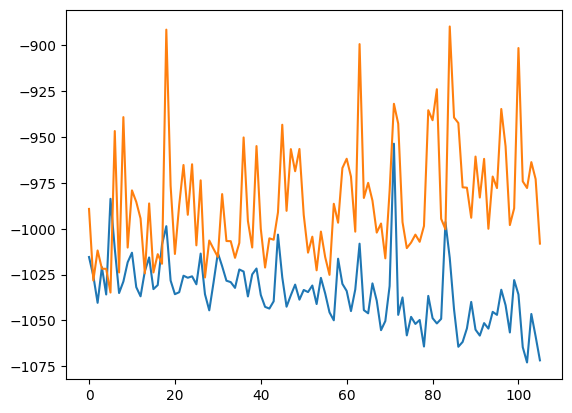

alpha 0.1 default_lr 0.0005


In [20]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [21]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [22]:
print(datetime.datetime.now())

2023-06-08 08:46:07.602426


Text(0, 0.5, 'loss')

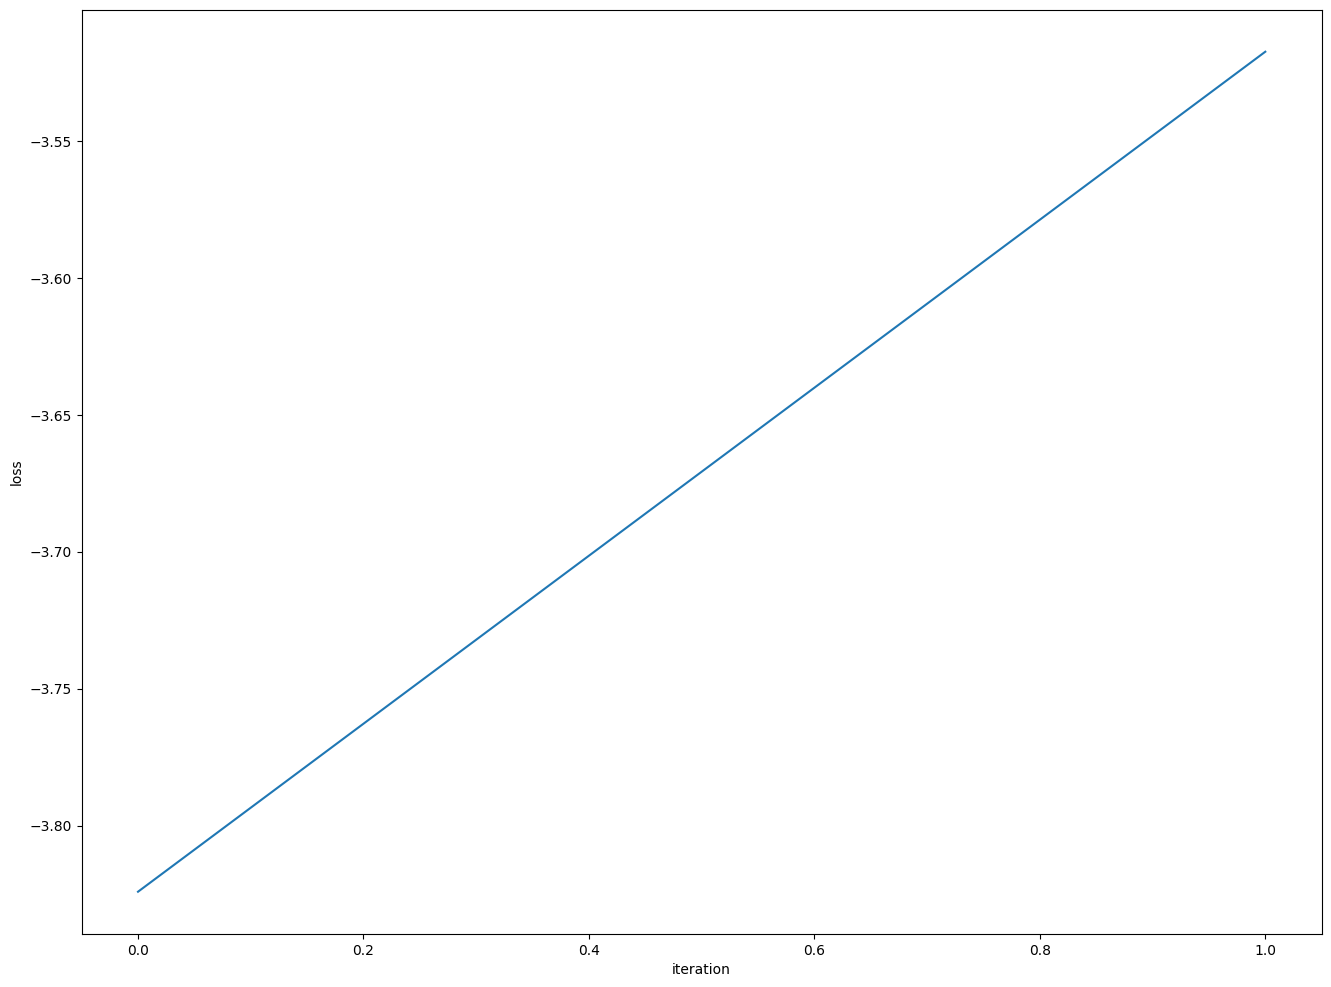

In [23]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


Text(0, 0.5, 'loss')

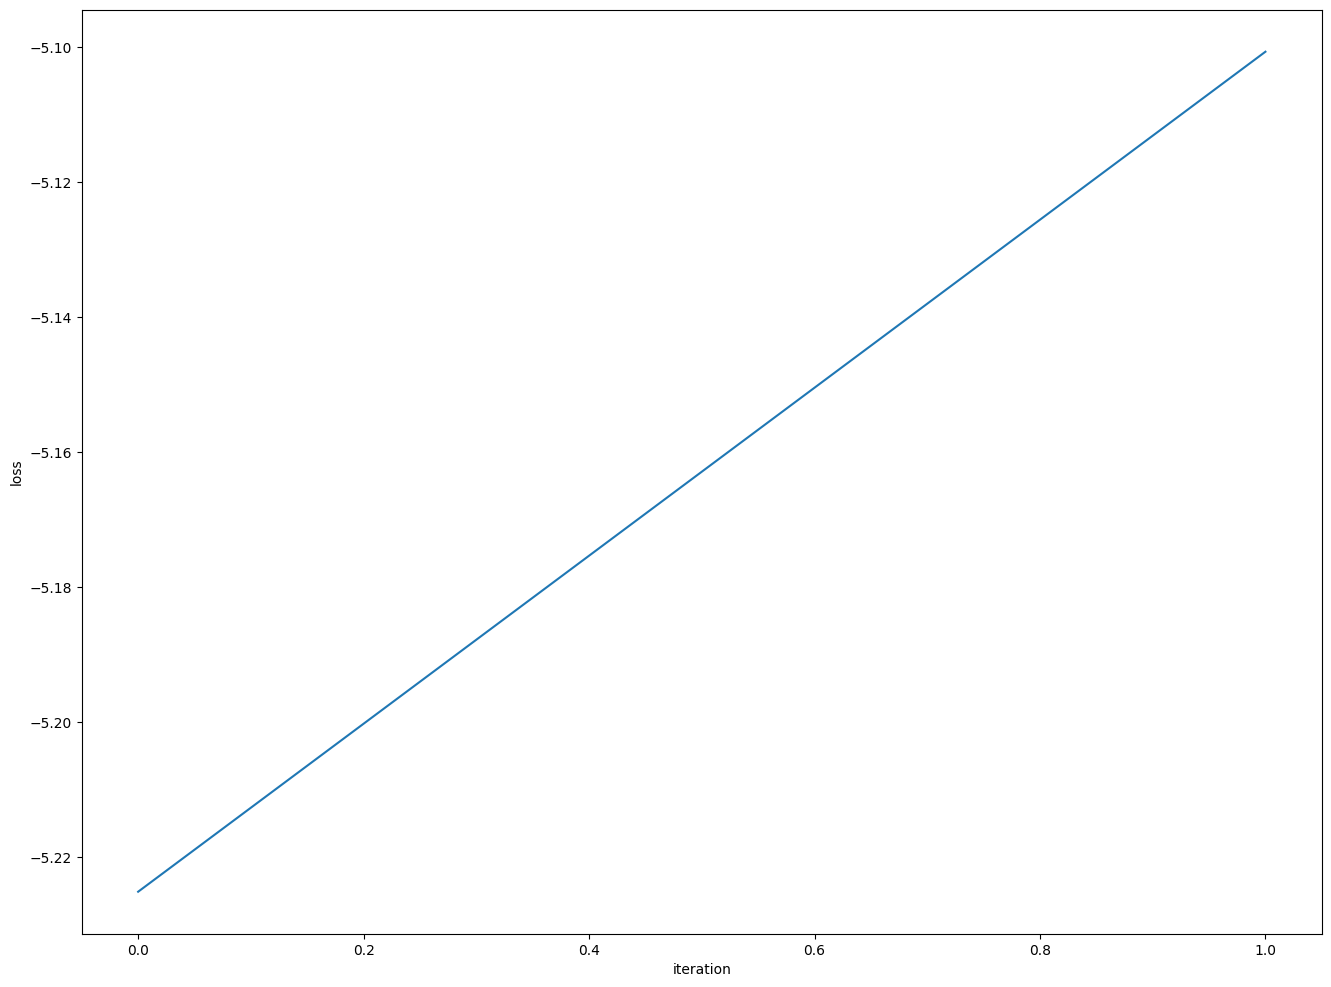

In [24]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


# Iter 3

In [25]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80
predict diverge [ 6.93065401  5.51726238 19.64300366 26.31542788] [-0.10137082  1.20201505  0.68242577  3.97821707] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 198

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [26]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.66957  validloss 1.06559±0.00000  bestvalidloss 1.06559  last_update 0
train: iter 1  trainloss 0.54657  validloss 0.60095±0.00000  bestvalidloss 0.60095  last_update 0
train: iter 2  trainloss 0.53179  validloss 0.58340±0.00000  bestvalidloss 0.58340  last_update 0
train: iter 3  trainloss 0.51371  validloss 0.57332±0.00000  bestvalidloss 0.57332  last_update 0
train: iter 4  trainloss 0.49913  validloss 0.57834±0.00000  bestvalidloss 0.57332  last_update 1
train: iter 5  trainloss 0.48878  validloss 0.54886±0.00000  bestvalidloss 0.54886  last_update 0
train: iter 6  trainloss 0.48210  validloss 0.55325±0.00000  bestvalidloss 0.54886  last_update 1
train: iter 7  trainloss 0.48148  validloss 0.55220±0.00000  bestvalidloss 0.54886  last_update 2
train: iter 8  trainloss 0.47592  validloss 0.55844±0.00000  bestvalidloss 0.54886  last_update 3
train: iter 9  trainloss 0.46453  validloss 0.55238±0.00000  bestvalidloss 0.54886  last_update 4
train: iter 10  trai

train: iter 84  trainloss 0.35963  validloss 0.50107±0.00000  bestvalidloss 0.49269  last_update 3
train: iter 85  trainloss 0.36077  validloss 0.50281±0.00000  bestvalidloss 0.49269  last_update 4
train: iter 86  trainloss 0.36082  validloss 0.50569±0.00000  bestvalidloss 0.49269  last_update 5
train: iter 87  trainloss 0.35924  validloss 0.49271±0.00000  bestvalidloss 0.49269  last_update 6
train: iter 88  trainloss 0.36114  validloss 0.49651±0.00000  bestvalidloss 0.49269  last_update 7
train: iter 89  trainloss 0.35639  validloss 0.50432±0.00000  bestvalidloss 0.49269  last_update 8
train: iter 90  trainloss 0.35617  validloss 0.49286±0.00000  bestvalidloss 0.49269  last_update 9
train: iter 91  trainloss 0.37840  validloss 0.55996±0.00000  bestvalidloss 0.49269  last_update 10
train: iter 92  trainloss 0.36189  validloss 0.49478±0.00000  bestvalidloss 0.49269  last_update 11
train: iter 93  trainloss 0.35526  validloss 0.49818±0.00000  bestvalidloss 0.49269  last_update 12
train: 

train: iter 167  trainloss 0.33766  validloss 0.48128±0.00000  bestvalidloss 0.47957  last_update 45
train: iter 168  trainloss 0.34696  validloss 0.48396±0.00000  bestvalidloss 0.47957  last_update 46
train: iter 169  trainloss 0.34140  validloss 0.49194±0.00000  bestvalidloss 0.47957  last_update 47
train: iter 170  trainloss 0.33626  validloss 0.49137±0.00000  bestvalidloss 0.47957  last_update 48
train: iter 171  trainloss 0.33635  validloss 0.51923±0.00000  bestvalidloss 0.47957  last_update 49
train: iter 172  trainloss 0.33286  validloss 0.49241±0.00000  bestvalidloss 0.47957  last_update 50
train: iter 173  trainloss 0.33164  validloss 0.47579±0.00000  bestvalidloss 0.47579  last_update 0
train: iter 174  trainloss 0.33889  validloss 0.51642±0.00000  bestvalidloss 0.47579  last_update 1
train: iter 175  trainloss 0.34287  validloss 0.50135±0.00000  bestvalidloss 0.47579  last_update 2
train: iter 176  trainloss 0.33044  validloss 0.53896±0.00000  bestvalidloss 0.47579  last_upd

train: iter 249  trainloss 0.32579  validloss 0.48361±0.00000  bestvalidloss 0.47566  last_update 34
train: iter 250  trainloss 0.32174  validloss 0.48200±0.00000  bestvalidloss 0.47566  last_update 35
train: iter 251  trainloss 0.32540  validloss 0.47457±0.00000  bestvalidloss 0.47457  last_update 0
train: iter 252  trainloss 0.32025  validloss 0.48892±0.00000  bestvalidloss 0.47457  last_update 1
train: iter 253  trainloss 0.32193  validloss 0.47599±0.00000  bestvalidloss 0.47457  last_update 2
train: iter 254  trainloss 0.32492  validloss 0.48555±0.00000  bestvalidloss 0.47457  last_update 3
train: iter 255  trainloss 0.31846  validloss 0.48838±0.00000  bestvalidloss 0.47457  last_update 4
train: iter 256  trainloss 0.32648  validloss 0.48923±0.00000  bestvalidloss 0.47457  last_update 5
train: iter 257  trainloss 0.31937  validloss 0.48651±0.00000  bestvalidloss 0.47457  last_update 6
train: iter 258  trainloss 0.32425  validloss 0.49416±0.00000  bestvalidloss 0.47457  last_update 

train: iter 331  trainloss 0.31421  validloss 0.48494±0.00000  bestvalidloss 0.47432  last_update 15
train: iter 332  trainloss 0.31309  validloss 0.49311±0.00000  bestvalidloss 0.47432  last_update 16
train: iter 333  trainloss 0.31297  validloss 0.48492±0.00000  bestvalidloss 0.47432  last_update 17
train: iter 334  trainloss 0.31011  validloss 0.47579±0.00000  bestvalidloss 0.47432  last_update 18
train: iter 335  trainloss 0.31408  validloss 0.49076±0.00000  bestvalidloss 0.47432  last_update 19
train: iter 336  trainloss 0.31323  validloss 0.47481±0.00000  bestvalidloss 0.47432  last_update 20
train: iter 337  trainloss 0.31099  validloss 0.48990±0.00000  bestvalidloss 0.47432  last_update 21
train: iter 338  trainloss 0.31394  validloss 0.47563±0.00000  bestvalidloss 0.47432  last_update 22
train: iter 339  trainloss 0.31121  validloss 0.48754±0.00000  bestvalidloss 0.47432  last_update 23
train: iter 340  trainloss 0.31458  validloss 0.48468±0.00000  bestvalidloss 0.47432  last_

train: iter 414  trainloss 0.30203  validloss 0.48331±0.00000  bestvalidloss 0.46813  last_update 22
train: iter 415  trainloss 0.30238  validloss 0.48231±0.00000  bestvalidloss 0.46813  last_update 23
train: iter 416  trainloss 0.30477  validloss 0.49396±0.00000  bestvalidloss 0.46813  last_update 24
train: iter 417  trainloss 0.29960  validloss 0.48642±0.00000  bestvalidloss 0.46813  last_update 25
train: iter 418  trainloss 0.30167  validloss 0.48441±0.00000  bestvalidloss 0.46813  last_update 26
train: iter 419  trainloss 0.30065  validloss 0.48761±0.00000  bestvalidloss 0.46813  last_update 27
train: iter 420  trainloss 0.30354  validloss 0.48567±0.00000  bestvalidloss 0.46813  last_update 28
train: iter 421  trainloss 0.30060  validloss 0.47800±0.00000  bestvalidloss 0.46813  last_update 29
train: iter 422  trainloss 0.30019  validloss 0.49185±0.00000  bestvalidloss 0.46813  last_update 30
train: iter 423  trainloss 0.30392  validloss 0.49812±0.00000  bestvalidloss 0.46813  last_

([0.6695699414238334,
  0.5465681038796901,
  0.5317914593964815,
  0.5137118510901928,
  0.4991322303190827,
  0.4887848861515522,
  0.4821036022156477,
  0.4814837845042348,
  0.4759241286665201,
  0.46452945191413164,
  0.4674905626103282,
  0.462698108702898,
  0.45855362629517915,
  0.45810391623526814,
  0.44980611503124235,
  0.4482125144451857,
  0.4431881122291088,
  0.43642592784017326,
  0.4338240636512637,
  0.42770425919443367,
  0.4232176342979074,
  0.4221510553732514,
  0.4172058653086424,
  0.42405791925266384,
  0.41916167326271536,
  0.4215864783152938,
  0.41207532696425914,
  0.40687139611691236,
  0.4097709677182138,
  0.402444919385016,
  0.4016251085326076,
  0.4013491873629391,
  0.40497024860233066,
  0.402346810977906,
  0.394762862380594,
  0.393969969637692,
  0.3919017422012985,
  0.39305459149181843,
  0.39073204156011343,
  0.3938884791918099,
  0.38755457969382406,
  0.39424079526215794,
  0.38893703538924457,
  0.3886451578699052,
  0.3806880647316575,

In [27]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.261459637543559
valid_loss:  -10.781543678474424
weight_alpha 1.0 h_min_tilde -11.9393215 ell_tilde -5.5654764457297325 kappa_tilde 0.00039609489811022735
train_loss:  -4.75816049079895
valid_loss:  -4.624703102111817
weight_alpha 0.1 h_min_tilde -11.9393215 ell_tilde -4.731469013061524 kappa_tilde 0.0003724749362355279


In [28]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -956.07354  validloss -924.94679±0.00000  bestvalidloss -924.94679  last_update 0
train: iter 1  trainloss -979.51046  validloss -933.70654±0.00000  bestvalidloss -933.70654  last_update 0
train: iter 2  trainloss -976.65010  validloss -956.80009±0.00000  bestvalidloss -956.80009  last_update 0
train: iter 3  trainloss -963.81464  validloss -904.08095±0.00000  bestvalidloss -956.80009  last_update 1
train: iter 4  trainloss -979.05916  validloss -905.49727±0.00000  bestvalidloss -956.80009  last_update 2
train: iter 5  trainloss -962.31238  validloss -752.41581±0.00000  bestvalidloss -956.80009  last_update 3
train: iter 6  trainloss -973.80683  validloss -906.57834±0.00000  bestvalidloss -956.80009  last_update 4
train: iter 7  trainloss -969.76272  validloss -938.46681±0.00000  bestvalidloss -956.80009  last_update 5
train: iter 8  trainloss -865.70158  validloss -791.03712±0.00000  bestvalidloss -956.80009  last_u

train: iter 77  trainloss -985.83951  validloss -897.22668±0.00000  bestvalidloss -994.03106  last_update 63
train: iter 78  trainloss -991.98619  validloss -924.62101±0.00000  bestvalidloss -994.03106  last_update 64
train: iter 79  trainloss -1004.11933  validloss -907.73616±0.00000  bestvalidloss -994.03106  last_update 65
train: iter 80  trainloss -994.64955  validloss -974.73402±0.00000  bestvalidloss -994.03106  last_update 66
train: iter 81  trainloss -976.10133  validloss -882.31759±0.00000  bestvalidloss -994.03106  last_update 67
train: iter 82  trainloss -997.34898  validloss -968.23815±0.00000  bestvalidloss -994.03106  last_update 68
train: iter 83  trainloss -998.53522  validloss -906.58216±0.00000  bestvalidloss -994.03106  last_update 69
train: iter 84  trainloss -999.03593  validloss -936.16634±0.00000  bestvalidloss -994.03106  last_update 70
train: iter 85  trainloss -1000.41846  validloss -902.69847±0.00000  bestvalidloss -994.03106  last_update 71
train: iter 86  t

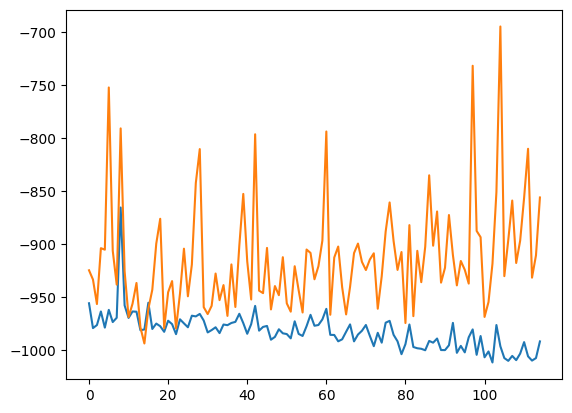

alpha 0.1 default_lr 0.0005


In [29]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [30]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [31]:
print(datetime.datetime.now())

2023-06-08 09:04:46.141585


# 評価関数計算

In [32]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8
predict diverge [ 4.60852365 10.71878087 27.85605675 18.54237328] [0.06827213 1.21390961 0.37436434 0.81366329] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 197

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24
predict diverge [ 5.52945797  0.48937653 15.61040076 22.59813814] [0.02621248 0.88762553 0.50230355 2.31252551] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 111

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83
predict diverge [ 5.87992472  1.12113602 15.76173211 22.92813255] [0.04026999 0.329478   0.56308955 1.93919077] [32.84908  10.318261 49.842476 22.503405] [1

In [33]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.52658  validloss 1.06928±0.00000  bestvalidloss 1.06928  last_update 0
train: iter 1  trainloss 0.45917  validloss 0.68739±0.00000  bestvalidloss 0.68739  last_update 0
train: iter 2  trainloss 0.44078  validloss 0.65611±0.00000  bestvalidloss 0.65611  last_update 0
train: iter 3  trainloss 0.42780  validloss 0.65069±0.00000  bestvalidloss 0.65069  last_update 0
train: iter 4  trainloss 0.42066  validloss 0.62231±0.00000  bestvalidloss 0.62231  last_update 0
train: iter 5  trainloss 0.41934  validloss 0.61931±0.00000  bestvalidloss 0.61931  last_update 0
train: iter 6  trainloss 0.40717  validloss 0.61997±0.00000  bestvalidloss 0.61931  last_update 1
train: iter 7  trainloss 0.40915  validloss 0.62661±0.00000  bestvalidloss 0.61931  last_update 2
train: iter 8  trainloss 0.40526  validloss 0.63020±0.00000  bestvalidloss 0.61931  last_update 3
train: iter 9  trainloss 0.39982  validloss 0.62453±0.00000  bestvalidloss 0.61931  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.33717  validloss 0.58235±0.00000  bestvalidloss 0.57456  last_update 7
train: iter 84  trainloss 0.34040  validloss 0.57592±0.00000  bestvalidloss 0.57456  last_update 8
train: iter 85  trainloss 0.33663  validloss 0.60064±0.00000  bestvalidloss 0.57456  last_update 9
train: iter 86  trainloss 0.33872  validloss 0.61519±0.00000  bestvalidloss 0.57456  last_update 10
train: iter 87  trainloss 0.33724  validloss 0.57789±0.00000  bestvalidloss 0.57456  last_update 11
train: iter 88  trainloss 0.33127  validloss 0.57486±0.00000  bestvalidloss 0.57456  last_update 12
train: iter 89  trainloss 0.33868  validloss 0.58756±0.00000  bestvalidloss 0.57456  last_update 13
train: iter 90  trainloss 0.33761  validloss 0.60452±0.00000  bestvalidloss 0.57456  last_update 14
train: iter 91  trainloss 0.33413  validloss 0.58663±0.00000  bestvalidloss 0.57456  last_update 15
train: iter 92  trainloss 0.33383  validloss 0.58054±0.00000  bestvalidloss 0.57456  last_update 16
tra

train: iter 165  trainloss 0.31963  validloss 0.62107±0.00000  bestvalidloss 0.55910  last_update 57
train: iter 166  trainloss 0.31979  validloss 0.60387±0.00000  bestvalidloss 0.55910  last_update 58
train: iter 167  trainloss 0.31633  validloss 0.60548±0.00000  bestvalidloss 0.55910  last_update 59
train: iter 168  trainloss 0.32719  validloss 0.62475±0.00000  bestvalidloss 0.55910  last_update 60
train: iter 169  trainloss 0.31671  validloss 0.57745±0.00000  bestvalidloss 0.55910  last_update 61
train: iter 170  trainloss 0.31577  validloss 0.61888±0.00000  bestvalidloss 0.55910  last_update 62
train: iter 171  trainloss 0.32468  validloss 0.58189±0.00000  bestvalidloss 0.55910  last_update 63
train: iter 172  trainloss 0.31629  validloss 0.63904±0.00000  bestvalidloss 0.55910  last_update 64
train: iter 173  trainloss 0.31650  validloss 0.57247±0.00000  bestvalidloss 0.55910  last_update 65
train: iter 174  trainloss 0.31513  validloss 0.57800±0.00000  bestvalidloss 0.55910  last_

([0.5265750585123896,
  0.4591676819138229,
  0.44077809499576687,
  0.4278013315983117,
  0.4206580612808466,
  0.41933882059529426,
  0.407166981138289,
  0.40915410770103333,
  0.4052649256773293,
  0.3998238446190953,
  0.3942989042960107,
  0.39922224087640645,
  0.3895302712917328,
  0.38762280801311133,
  0.39357191100716593,
  0.3814226794522256,
  0.3782317929901183,
  0.3814904931932688,
  0.37343465676531196,
  0.37987064216285943,
  0.3714969312772155,
  0.37052818313241004,
  0.3745667837560177,
  0.37445403877645733,
  0.3678648410364985,
  0.36414503804408016,
  0.364531176071614,
  0.3700531999580562,
  0.3606266645714641,
  0.3661009554751217,
  0.36278675282374023,
  0.3554754708893597,
  0.3599808037746698,
  0.36241517774760723,
  0.36008285228163006,
  0.35833979160524904,
  0.3557683146093041,
  0.35410230662673714,
  0.35879418523982165,
  0.3560989868827164,
  0.3537931471131742,
  0.35631068237125874,
  0.35322028743103145,
  0.3522035514935851,
  0.35292668119

In [34]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -3.730000632411241
valid_loss:  -9.32788349957466
weight_alpha 1.0 h_min_tilde -11.698145 ell_tilde -4.849577205843925 kappa_tilde 0.00038212031154952626
train_loss:  -4.879653613090516
valid_loss:  -3.8977010040283204
weight_alpha 0.1 h_min_tilde -11.698145 ell_tilde -4.683263091278078 kappa_tilde 0.00037756334107903603


In [35]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 194.10591  validloss 210.21807±0.00000  bestvalidloss 210.21807  last_update 0
train: iter 1  trainloss 161.88677  validloss 172.97421±0.00000  bestvalidloss 172.97421  last_update 0
train: iter 2  trainloss 136.83696  validloss 144.95881±0.00000  bestvalidloss 144.95881  last_update 0
train: iter 3  trainloss 115.29840  validloss 123.14347±0.00000  bestvalidloss 123.14347  last_update 0
train: iter 4  trainloss 97.58847  validloss 104.98554±0.00000  bestvalidloss 104.98554  last_update 0
train: iter 5  trainloss 83.31470  validloss 88.88441±0.00000  bestvalidloss 88.88441  last_update 0
train: iter 6  trainloss 71.74188  validloss 75.15159±0.00000  bestvalidloss 75.15159  last_update 0
train: iter 7  trainloss 62.10965  validloss 64.98100±0.00000  bestvalidloss 64.98100  last_update 0
train: iter 8  trainloss 53.02023  validloss 56.50957±0.00000  bestvalidloss 56.50957  last_update 0
train: iter 9  trainloss 46.33923  validloss 48.97425±0.00000  bestvalidloss 

train: iter 91  trainloss -0.79161  validloss -0.04824±0.00000  bestvalidloss -0.20332  last_update 6
train: iter 92  trainloss -0.76408  validloss -0.00497±0.00000  bestvalidloss -0.20332  last_update 7
train: iter 93  trainloss -0.78421  validloss -0.17300±0.00000  bestvalidloss -0.20332  last_update 8
train: iter 94  trainloss -0.80405  validloss -0.09389±0.00000  bestvalidloss -0.20332  last_update 9
train: iter 95  trainloss -0.77023  validloss -0.10188±0.00000  bestvalidloss -0.20332  last_update 10
train: iter 96  trainloss -0.76201  validloss 0.01492±0.00000  bestvalidloss -0.20332  last_update 11
train: iter 97  trainloss -0.79100  validloss -0.09100±0.00000  bestvalidloss -0.20332  last_update 12
train: iter 98  trainloss -0.79994  validloss -0.14234±0.00000  bestvalidloss -0.20332  last_update 13
train: iter 99  trainloss -0.80592  validloss -0.15815±0.00000  bestvalidloss -0.20332  last_update 14
train: iter 100  trainloss -0.73350  validloss -0.03646±0.00000  bestvalidloss

In [36]:
print(iwvi.initial_belief)


Parameter containing:
tensor([ 2.6125,  1.3460, -4.4190, -2.8251], requires_grad=True)


In [37]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 2.19337  validloss 264.37594±0.00000  bestvalidloss 264.37594  last_update 0
train: iter 1  trainloss 1.80064  validloss 290.34572±0.00000  bestvalidloss 264.37594  last_update 1
train: iter 2  trainloss 1.74779  validloss 304.58910±0.00000  bestvalidloss 264.37594  last_update 2
train: iter 3  trainloss 1.71866  validloss 271.65217±0.00000  bestvalidloss 264.37594  last_update 3
train: iter 4  trainloss 1.73725  validloss 249.70817±0.00000  bestvalidloss 249.70817  last_update 0
train: iter 5  trainloss 1.70571  validloss 250.22973±0.00000  bestvalidloss 249.70817  last_update 1
train: iter 6  trainloss 1.68900  validloss 280.24844±0.00000  bestvalidloss 249.70817  last_update 2
train: iter 7  trainloss 1.70670  validloss 253.00791±0.00000  bestvalidloss 249.70817  last_update 3
train: iter 8  trainloss 1.67282  validloss 189.06937±0.00000  bestvalidloss 189.06937  last_update 0
train: iter 9  trainloss 1.67066  validloss 290.21759±0.00000  bestvalidloss 189.0

train: iter 80  trainloss 1.63519  validloss 304.74527±0.00000  bestvalidloss 189.06937  last_update 72
train: iter 81  trainloss 1.59896  validloss 236.70620±0.00000  bestvalidloss 189.06937  last_update 73
train: iter 82  trainloss 1.60138  validloss 257.64893±0.00000  bestvalidloss 189.06937  last_update 74
train: iter 83  trainloss 1.57237  validloss 230.30458±0.00000  bestvalidloss 189.06937  last_update 75
train: iter 84  trainloss 1.62920  validloss 285.84059±0.00000  bestvalidloss 189.06937  last_update 76
train: iter 85  trainloss 1.58758  validloss 321.69622±0.00000  bestvalidloss 189.06937  last_update 77
train: iter 86  trainloss 1.61484  validloss 274.19635±0.00000  bestvalidloss 189.06937  last_update 78
train: iter 87  trainloss 1.59610  validloss 286.72832±0.00000  bestvalidloss 189.06937  last_update 79
train: iter 88  trainloss 1.64073  validloss 314.57707±0.00000  bestvalidloss 189.06937  last_update 80
train: iter 89  trainloss 1.62168  validloss 278.83097±0.00000  

In [38]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-3.2857)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-8.7015)


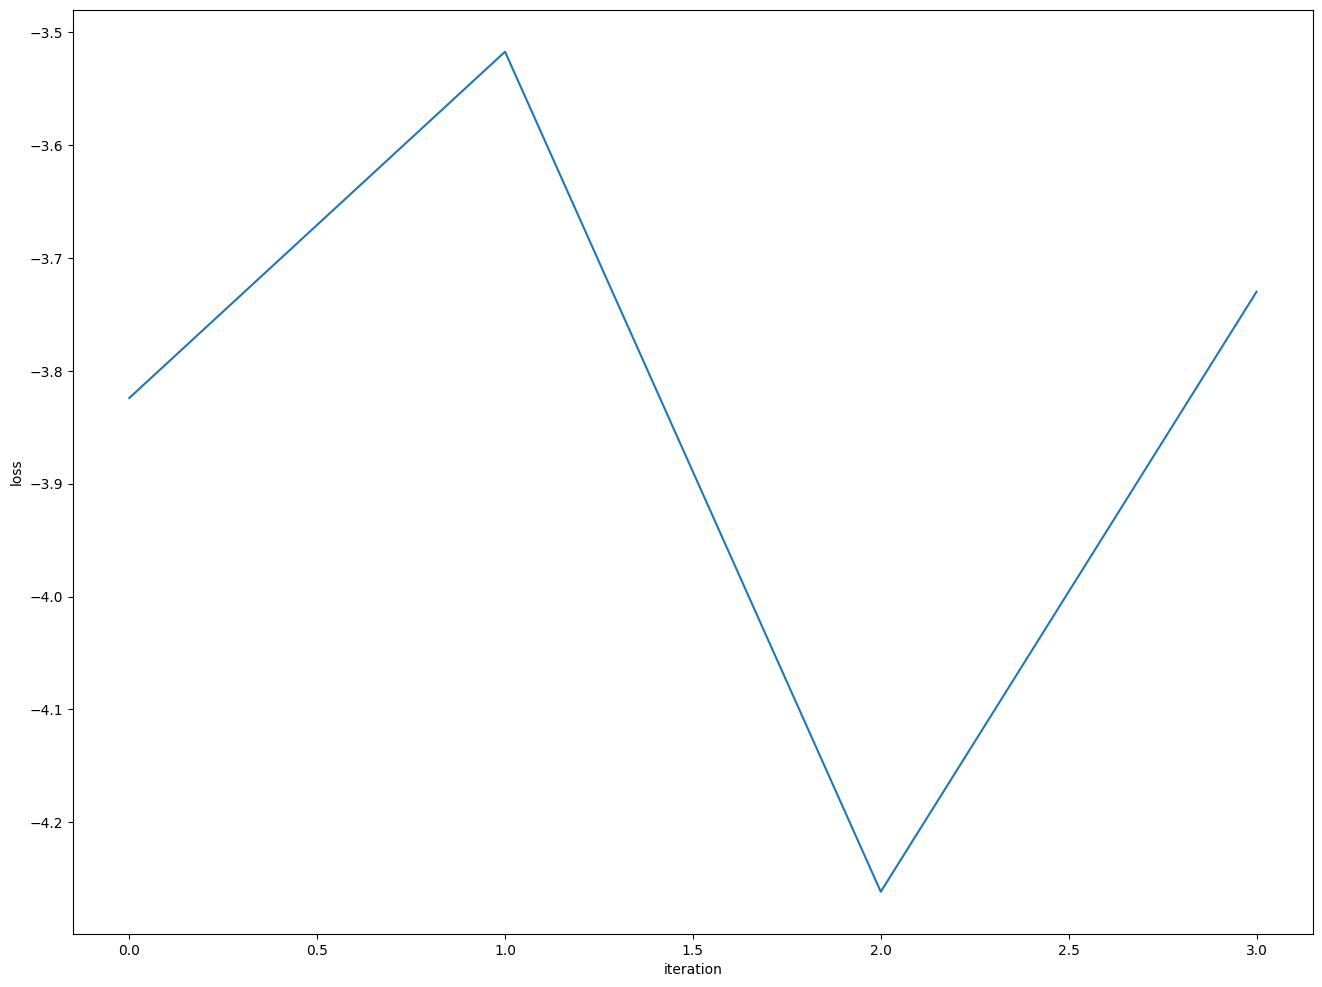

In [39]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

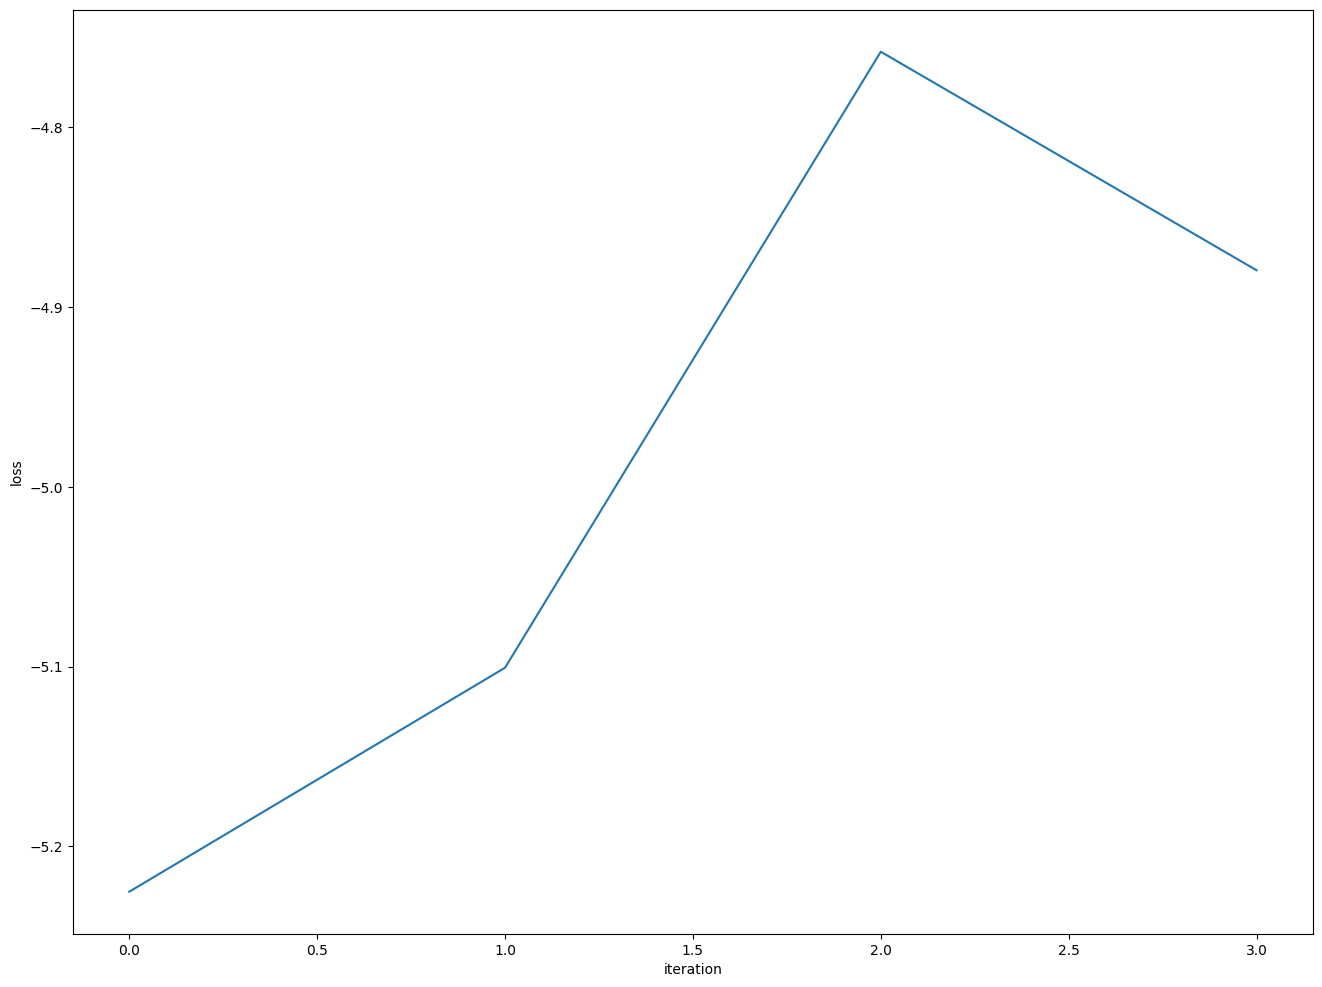

In [40]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")